1. refer = 1 then hosp gps 
2. sample of hospital gps - boot strap - if came from a hosp but no name 
3. random sample of the admin unit 

* select seed for randomization 
- restrict year to 2016 =<

1. mapping of patients 
2. network analysis (dependent: gps of kirtipur | road network, assigned speed limit (1st, 2nd, 3rd), place of origin, overlay topograpgy ==> time variable 
3. Dependent variable = admission condition (good vs ANY infection) 
  a. time from injury to admission
  b. travel time not distance 
  c. specific places (hosp) proportions of patients admitted in poor condition vs admitted in fine condition 
   - any problems --> poor 
  d. days treated at another - Are patient inapprop held 
  e. sweet spot of pre transfer time (burn size, area of burned) - data driven 
4. After Jan
  a. location allocation model

In [0]:
# All of the packages that need to be downloaded
%%capture
!pip install overpass
!pip install overpy
!pip install geojson
!pip install geojsonio
!pip install openrouteservice
!pip install geopandas
!pip install plotly==4.3.0
#!pip install fuzzywuzzy
#!pip install python-Levenshtein

In [0]:
import os 
import re
import json
from fuzzywuzzy import fuzz, process
from datetime import datetime, timedelta
import numpy as np
import pandas as pd # data import and maniplation 
import matplotlib.pyplot as plt # data visualization 
import plotly.offline as py
import seaborn as sns 
import plotly.graph_objects as go

# geospatial packages
import overpass
import overpy 
import geojson
import geojsonio
from geojson import Feature, FeatureCollection, Point
import openrouteservice
import geopandas

from sklearn import datasets, linear_model # regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split # data split 
from random import randint
import fiona

sns.set_style("whitegrid")
api = overpy.Overpass()

In [9]:
# if I want to change between google collab or spyder 
if True:
    from google.colab import files
    files.upload()    

Saving export.geojson to export.geojson
Saving Nepal Cumulative Burns 2014-19 copy.xlsx to Nepal Cumulative Burns 2014-19 copy.xlsx


In [0]:
# data input
df = pd.read_excel('Nepal Cumulative Burns 2014-19 copy.xlsx')
df = df[df['Year'] != 2014]

# removes duplicate
df['Program'] = df['Program'].apply(lambda x: str(x).lower().strip().replace('silf', 'self').replace('wonder work', 'ww').replace('wonderwork', 'ww').replace('sef', 'self').replace('selff', 'self').replace('self1', 'self'))

# gives a patient number proxy 
df['patient'] = np.arange(len(df))
#len(df['Name of Hospital'].isna() == True)

# importing geojson from overpressturbo, formatting
nepal_map = geopandas.read_file("export.geojson")
nepal_map['name:en'] = nepal_map['name:en'].apply(lambda x: str(x).lower())
nepal_map['name:en'] = nepal_map['name:en'].str.replace('sindhupalchowk', 'sindhupalchok')
nepal_map['id'] = np.arange(len(nepal_map))

Geocoding:

Open steet map 
https://wiki.openstreetmap.org/wiki/Tag:boundary%3Dadministrative#10_admin_level_values_for_specific_countries

Admin level:
- 3: Province
- 4: Dev Region
- 5: Zones
- 6: Districts
- 7: Municipalities 
- 8 Cities/Villages

# Overpass/OSM queries

In [0]:
# DISTRICT query 
# This is where you can call the tags for the particular id then get the meta data 
# result.relations[1].tags, gets the center lat for the relation 

district = api.query("""
[out:json];
area["ISO3166-1"="NP"][admin_level = 2]->.boundaryarea;  
(
  rel(area..boundaryarea)[admin_level="6"];
);
out center meta;""")

district_map = {}
for rel in district.relations:
  district_map[rel.tags['name:en'].lower()] = [float(rel.center_lon),float(rel.center_lat)]
  #print( + ' | ' + 'lon: ' + str() + ' lat: ' + str())

In [0]:
# gets all villages in Nepal
villages = api.query("""
[out:json];
area["ISO3166-1"="NP"][admin_level = 2]->.boundaryarea;  
(
  rel(area..boundaryarea)[admin_level="8"]; 
);
out center meta;
""")

village_map = {}
error = 0
for rel in villages.relations:
  if (rel.tags.get('name:en', "empty") != 'empty'):
    village_map[rel.tags['name:en'].lower()] = [float(rel.center_lon),float(rel.center_lat)]
  elif (rel.tags.get('name', "empty") != 'empty'):
    village_map[rel.tags['name'].lower()] = [float(rel.center_lon),float(rel.center_lat)]
  else: 
    village_map[error] = rel
    error += 1
village_map.pop('error', None)

# Formatting address and district naming

In [0]:
# Processes the formatting and spelling of addresses
df['Address'] = df['Address'].apply(lambda x: str(x).lower().strip().replace('ktm', 'kathmandu').replace('accham', 'achham').replace('agrakhanchi', 'arghakhanchi').replace('argakhachi', 'arghakhanchi').replace('argakhanchi', 'arghakhanchi').replace('arghakhachi', 'arghakhanchi').replace('baglong', 'baglung').replace('bajhang', 'bajang').replace('bhairawa', 'bhairahawa').replace('bharatpur','bhaktapur').replace('bhkatapur','bhaktapur').replace('butuwal','butwal').replace('bajang','bajhang').replace('chayanpur','chainpur').replace('dailekha','dailekh').replace('dhangadi','dhangari').replace('dhanusa','dhanusha').replace('dhanushaa','dhanusha').replace('dhulekhel','dhulikhel').replace('dolakaha','dolakha').replace('dolkaha','dolakha').replace('illam','ilam').replace('ithari','itahari').replace('ittahari','itahari').replace('kapilbastu','kapilvastu').replace('kavrepalanchowk','kavrepalanchok').replace('kavre','kavrepalanchok').replace('kirtipipur','kirtipur').replace('kohalpir','kohalpur').replace('kuleshor','kuleshwor').replace('lamgunj','lamjung').replace('llitpur','lalitpur').replace('mahatori','mahottari').replace('mahatari','mahottari').replace('mahotari','mahottari').replace('makawanpur','makwanpur').replace('nawalparashi','nawalparasi').replace('nawalparasi','nawalparasi').replace('nepaljung','nepalgunj').replace('okahaldhunga','okhaldhunga').replace('okaldhunga','okhaldhunga').replace('parsha','parsa').replace('pokahara','pokhara').replace('ramechap','ramechhap').replace('samkhuwasabha','sankhuwasabha').replace('sankhuwasava','sankhuwasabha').replace('sakhawasaba','sankhuwasabha').replace('sangjhya','sanghiya').replace('saralahi','sarlahi').replace('shankhuwashabha','sankhuwasabha').replace('shyanja','shyangja').replace('simra','simara').replace('simra','simara').replace('sindhui','sindhuli').replace('sindhupalchowk','sindhupalchok').replace('sinduli','sindhuli').replace('sindupalchok','sindhupalchok').replace('sindupalchowk','sindhupalchok').replace('snkhuwasabha','sankhuwasabha').replace('syanja','syangja').replace('syanjha','syangja').replace('tanahu','tanahun').replace('taplegunj','taplejung').replace('taudhaha','taudaha').replace('terathum','tehrathum').replace('udaypur','udayapur'))
df['Address2'] = df['Address'].apply(lambda x: str(x).lower().strip().replace(', ', ',').replace('- ', '-').split(','))

# extracts district and village from the query / shapefile
df['district'] = df['Address2'].apply(lambda x: [y for y in x if y in list(nepal_map['name:en'].unique())]).apply(lambda x: x[0] if x != [] else '')
df['village']  = df['Address2'].apply(lambda x: [y for y in x if y in list(village_map.keys())]).apply(lambda x: x[0] if x != [] else '')

In [0]:
# Noting the amount of noted hosp and matching names for district and village 
df[(df['village'] != '') & (df['district'] != '') & ~(df['Name of Hospital'].isna())]
(df['Name of Hospital'].apply(lambda x: str(x).lower())).unique()

# Merging gps with location data

In [0]:
# district/village df are in an odd data format 
# turning both into a df  
df_distmap = pd.Series(district_map, name = 'dist_map')
df_distmap.index.name = 'district'
df_distmap = df_distmap.reset_index()

df_villmap = pd.Series(village_map, name = 'vill_map')
df_villmap.index.name = 'village'
df_villmap = df_villmap.reset_index()

In [0]:
# Creating a column of patient counters  
# * Gotta convert to df first before anything or else python thinks its a relation 
nepal_map = nepal_map.merge(pd.DataFrame(df.groupby(['district'])['district'].size().reset_index(name='counts'))[1:], how ='left' , left_on = 'name:en', right_on = 'district')
nepal_map[['counts']] = nepal_map[['counts']].fillna(value = 0)

vill_merge = pd.DataFrame( df.groupby(['village'])['village'].size().reset_index(name='counts') )[1:].merge(df_villmap, how ='left', on = 'village' )
vill_merge['long'] = vill_merge['vill_map'].apply(lambda x: x[0])
vill_merge['lat'] = vill_merge['vill_map'].apply(lambda x: x[1])

# Converting the city coords into a geopandas data df
nepal_cities = geopandas.GeoDataFrame(vill_merge, geometry=geopandas.points_from_xy(vill_merge.long, vill_merge.lat))
#dist_merge = df[df['village'] == ''][['patient','district']].merge(df_distmap, on = 'district' )
#vill_merge = df[df['district'] == ''][['patient','village']].merge(df_villmap, on = 'village' )

In [0]:
df['extract_dist'] = df['Address'].apply(lambda x: process.extractOne(x, list(df_distmap['district'])))
df['extract_vill'] = df['Address'].apply(lambda x: process.extractOne(x, list(df_villmap['village'])))

In [58]:
df[['village','district','extract_dist', 'extract_vill']]

,village,district,extract_dist,extract_vill
90,kathmandu,kathmandu,"(kathmandu, 100)","(kathmandu, 100)"
91,,lamjung,"(lamjung, 100)","(namjung, 86)"
92,,morang,"(morang, 100)","(orang, 91)"
93,rautahat,rautahat,"(rautahat, 100)","(rautahat, 100)"
94,,okhaldhunga,"(okhaldhunga, 100)","(hunga, 90)"
...,...,...,...,...
2096,,bara,"(bara, 100)","(baraigaun, 90)"
2097,,,"(rautahat, 93)","(rautahat, 93)"
2098,parsa,parsa,"(parsa, 100)","(parsa, 100)"
2099,,lalitpur,"(lalitpur, 100)","(lali, 90)"


# Nepal Map - Visuals

## plt - skip

/usr/local/lib/python3.6/dist-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


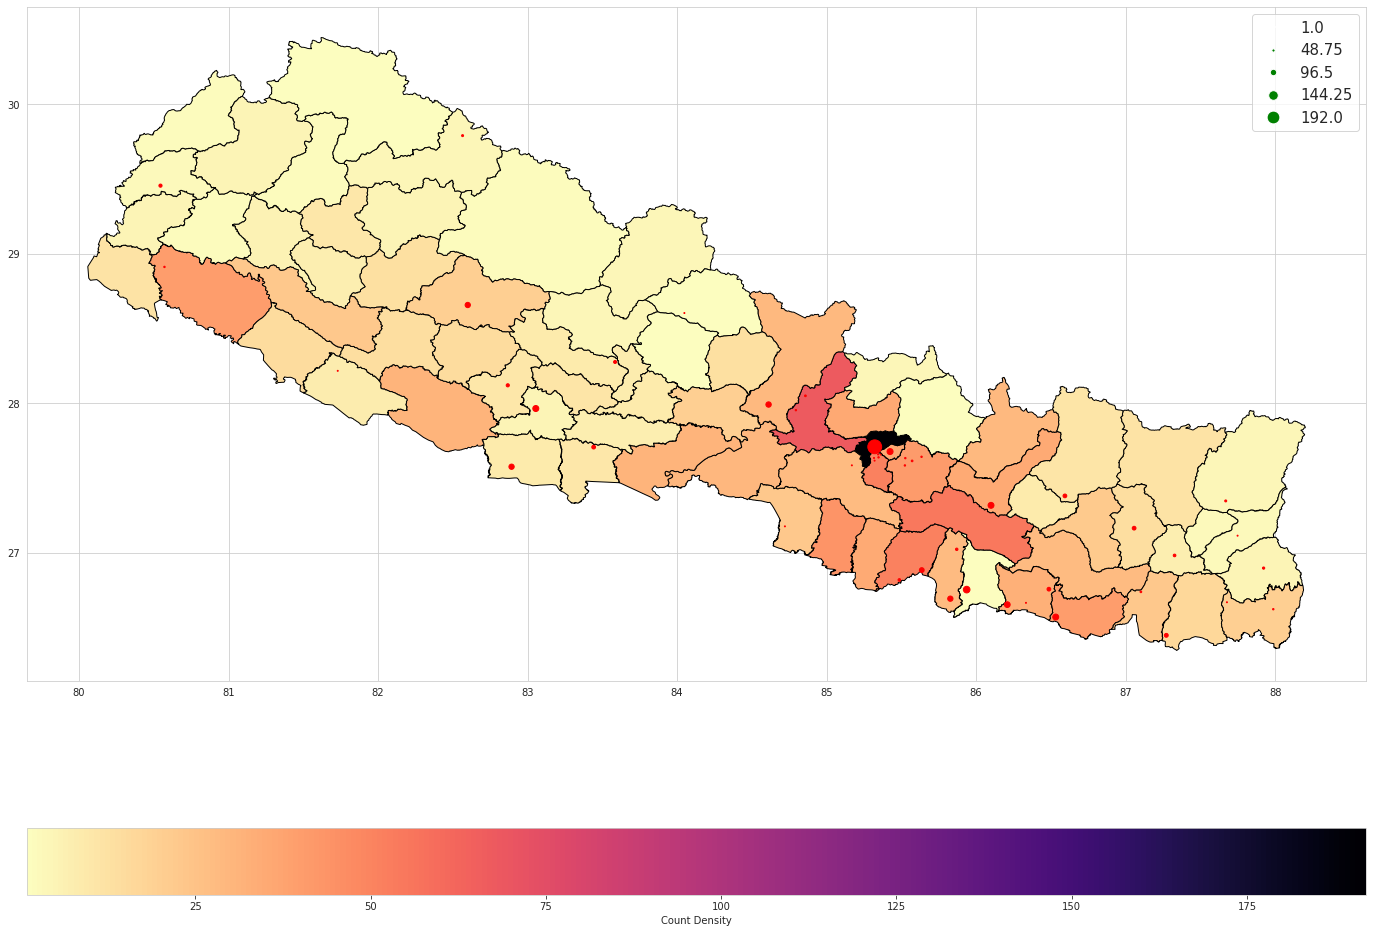

In [0]:
from matplotlib.lines import Line2D

f, ax = plt.subplots(1, figsize=(24, 18))
cmap_reversed  = plt.cm.get_cmap('magma_r')
# district grid 
ax = nepal_map[~nepal_map['admin_level'].isna()].plot(column =  'counts',
                                                      ax=ax, alpha = 1.0,
                                                      cmap=cmap_reversed, 
                                                      edgecolor='black',
                                                      legend = True,
                                                      legend_kwds={'orientation': "horizontal", 'label':'Count Density'})

# legend works, but it isnt that accurate 
legend_elements = [ Line2D([0], [0], marker='o', color='w', label= bins[i],  markerfacecolor='g', markersize=bins[i]/15)  for i in range(len(bins))   ]

# points for cities in nepal
test = nepal_cities.plot(ax=ax, color='red', markersize = nepal_cities['counts'])
ax.legend(handles = legend_elements , loc = 'upper right', prop={'size': 15})
mplcursors.cursor(hover = True)
plt.show()

## [Current] plotly

remaking map in plotly
https://plot.ly/~jackp/18273.embed

plotly works like building each layer on top of each other or modifying each other based on the function

In [0]:
# creating an overall layout template to apply to any furture attempts

lon1, lat1, lon2, lat2 = 79.4388,25.9092,88.7003,30.9781
layout = dict(
    hovermode = 'closest',
    mapbox = dict(
              style="carto-positron",
              zoom=6,
              center = dict(lat = 28.3949,
                            lon = 84.1240)),
    margin = dict(
        t=20,
        b=20,
        r=20,
        l=20
    ),
    width = 1100,
    height = 650,
    dragmode = 'zoom'
)

### First attempt - Pass

First attempt at making a interactable geodata plot 

Works but because it has to iteratively create the boundaries it is very poor when trying to create overall data metrics and only can't do color map without a lot of extra steps as I have to make the color to a particular value

In [0]:

plot_data = []
for index,row in nepal_map.iterrows():
    if nepal_map['geometry'][index].type == 'Polygon':
        x,y = np.asarray(row.geometry.exterior.xy)
        c_x,c_y = np.asarray(row.geometry.centroid.xy)
    elif nepal_map['geometry'][index].type == 'MultiPolygon':
        x = [poly.exterior.xy[0] for poly in nepal_map['geometry'][index]]
        y = [poly.exterior.xy[1] for poly in nepal_map['geometry'][index]]
        x_c = [poly.centroid.xy[0] for poly in nepal_map['geometry'][index]]
        y_c = [poly.centroid.xy[1] for poly in nepal_map['geometry'][index]]        
    else: 
        print('')
    county_outline = dict(
            type = 'scatter',
            showlegend = False,
            legendgroup = "shapes",
            line = dict(color='black', width=1),
            x=x,
            y=y,
            fill='toself',
            hoverinfo='none',
            fillcolor = 'purple'
    )
    hover_point = dict(
            type = 'scatter',
            showlegend = False,
            legendgroup = "centroids",
            text = row['name:en'],
            marker = dict(size=2),
            x=c_x,
            y=c_y,
            fill='toself',
            fillcolor = 'purple',
            hoverinfo  = 'text',
            hoverlabel = dict(bgcolor = 'white')
    )
    plot_data.append(county_outline)
    plot_data.append(hover_point)

In [0]:
fig = dict(data=plot_data, layout=layout)
py.iplot(fig)

Output hidden; open in https://colab.research.google.com to view.

### Current attempt 

Using choroplethmapbox which allows for a full build of the map without having to manual creation 

In [0]:
# Converts the geodata into a json & fills in any empty values as a 0 count
nepal_map_json = json.loads(nepal_map[nepal_map.geometry.type == 'Polygon'].to_json())
nepal_map_json['features'][0]['id'] = 90
if len(nepal_map[nepal_map['id'] == 0]) != 0:
  nepal_map['id'][0] = 90

In [0]:
vill_merge.head()

,village,counts,vill_map,long,lat,geometry
0,baglung,9,"[83.5851655, 28.2770405]",83.585166,28.277040,POINT (83.58517 28.27704)
1,banepa,2,"[85.5263945, 27.6339678]",85.526394,27.633968,POINT (85.52639 27.63397)
2,bardibas,6,"[85.8702579, 27.0241083]",85.870258,27.024108,POINT (85.87026 27.02411)
3,bhaktapur,36,"[85.4243527, 27.6777964]",85.424353,27.677796,POINT (85.42435 27.67780)
4,bhojpur,14,"[87.0567205, 27.1654605]",87.056720,27.165460,POINT (87.05672 27.16546)


In [0]:
# Creation of the mapbox with the first layer being the district then adding each layer on top 
# Adds an underlying map 
# Adds a scatter plot of the villages based on the size of the count 
fig = go.Figure(go.Choroplethmapbox(geojson=nepal_map_json, locations = nepal_map.id, z = nepal_map.counts,
                                    colorscale="magma",
                                    reversescale=True,
                                    marker_opacity=0.5, marker_line_width=1, 
                                    below = 'traces',
                                    hoverinfo = 'text+z',
                                    hovertext = nepal_map['name:en']))
fig.update_layout(layout)
fig.add_trace(go.Scattermapbox(
                  lat = vill_merge.lat,
                  lon = vill_merge.long,
                  mode = 'markers',
                  below = "",
                  hoverinfo = 'text',
                  hovertext = vill_merge.village + ': ' + (vill_merge.counts).astype(str) ,
                  marker=go.scattermapbox.Marker(
                    #size=vill_merge.counts/7, coming back to this as it breaks with KTM 
                    size=6,
                    color='rgb(0,206,209)',
                    opacity=1.0
                  )
              ))
fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [0]:
py.plot(fig, 'nepal.html')

'temp-plot.html'

# Routing:

- Only way to work is if its next to a road so centriod might not really work
- Villages would work in theory
- Would have to calculate some sort of average time/speed in a 500 m radius to make it equiravlent 

In [0]:
# Gets all healthcare/clinics in nepal
result = api.query("""
[out:json];
area["ISO3166-1"="NP"][admin_level = 2]->.boundaryarea;  
(
  node(area..boundaryarea)[amenity ='clinic'];
  node(area..boundaryarea)[amenity ='hospital'];  
);
out center meta;
""")

In [0]:
hosp_map = {}
error = 0
for node in result.nodes:
  if (node.tags.get('name:en', "empty") != 'empty'):
    hosp_map[node.tags['name:en'].lower()] = [float(node.lon),float(node.lat)]
  elif (node.tags.get('name', "empty") != 'empty'):
    hosp_map[node.tags['name'].lower()] = [float(node.lon),float(node.lat)]
  else: 
    hosp_map[error] = node
    error += 1   

hosp_map.pop('error', None)

In [0]:
# potential routing 
#https://github.com/GIScience/openrouteservice-py

coords = ((87.758145,27.136184),(88.092155,27.064514))

client = openrouteservice.Client(key='5b3ce3597851110001cf62484f6201ddb7ff4befa031f0b88b370d4c	') # Specify your personal API key
routes = client.directions(coords)

print(routes)

{'bbox': [87.755908, 26.868277, 88.135594, 27.136429], 'routes': [{'summary': {'distance': 147384.5, 'duration': 8874.5}, 'segments': [{'distance': 147384.5, 'duration': 8874.5, 'steps': [{'distance': 80134.9, 'duration': 4487.3, 'type': 11, 'instruction': 'Head southwest on मेची राजमार्ग, H07', 'name': 'मेची राजमार्ग, H07', 'way_points': [0, 3365]}, {'distance': 19996.1, 'duration': 1154.8, 'type': 0, 'instruction': 'Turn left onto मेची राजमार्ग, H07', 'name': 'मेची राजमार्ग, H07', 'way_points': [3365, 4247]}, {'distance': 10832.8, 'duration': 613.4, 'type': 12, 'instruction': 'Keep left onto Phikkal Pashupatinagar Road, F38', 'name': 'Phikkal Pashupatinagar Road, F38', 'way_points': [4247, 4764]}, {'distance': 6626.2, 'duration': 367.0, 'type': 0, 'instruction': 'Turn left onto Mirik Road, SH12', 'name': 'Mirik Road, SH12', 'way_points': [4764, 5039]}, {'distance': 2016.5, 'duration': 242.0, 'type': 2, 'instruction': 'Turn sharp left', 'name': '-', 'way_points': [5039, 5154]}, {'dist

In [0]:
#df['Treatment in another hospital? (1=yes,0=no)']
df['Name of Hospital'] = df['Name of Hospital'].apply(lambda x: str(x).lower())

In [0]:
#df[df['Name of Hospital'] =='bpkihs']['Name of Hospital'].apply(lambda x: [y for y in x if y in list(hosp_map.keys())])
df['hosp_name']  =  df['Name of Hospital'].apply(lambda x: hosp_map[x] if x in list(hosp_map.keys()) else '')

In [0]:
df['Address'].unique()

array(['KTM', 'Lamjung', 'Morang', 'Rautahat', 'Okhaldhunga', 'Ilam',
       'Tanahu', 'Itahari', 'Nawalparashi', 'Chitwan', 'Nuwakot', 'bara',
       'Dang', 'Nepaljung', 'Dhading', 'Dailekh', 'Damauli', 'Parsa',
       'khotang', 'rautahat', 'Butwal', 'lalitpur', 'Kavre', 'Kathmandu',
       'Dolakha', 'Bara', 'Kailali', 'Nawalparasi', 'Siraha', 'Sarlahi',
       'Shyangja', 'Khotang', 'kHOTANG', 'Dhankuta', 'Ghorkha',
       'Sindhupalchok', 'Lalitpur', 'Kirtipur', 'kirtipur', 'Rupandehi',
       'kirtipipur', 'Ramechhap', 'Bhojpur', 'Biratnagar', 'Banke',
       'Sindhuli', 'Bardia', 'Tehrathum', 'Sankhuwasabha', 'Jhapa',
       'Solukhumbu', 'Pokhara', 'Samkhuwasabha', 'Udayapur', 'Bhairahawa',
       'Bhaktapur', 'Bajhang', 'Surkhet', 'Rukum', 'Makwanpur', 'Saptari',
       'Doti', 'Dharan ', 'Trisuli', 'Gorkha', 'Baglung', 'Dolkha',
       'Ramkot', 'Hetauda', 'Balaju', 'Palpa', 'Godawari', 'Janakpur',
       'Bardiya', 'Nepalgunj', 'Baitadi', 'Kalikot', nan, 'Sunsari',
       '

1. refer = 1 then hosp gps 
2. sample of hospital gps - boot strap - if came from a hosp but no name 
3. random sample of the admin unit 

* select seed for randomization 
- restrict year to 2016 =<

1. mapping of patients 
2. network analysis (dependent: gps of kirtipur | road network, assigned speed limit (1st, 2nd, 3rd), place of origin, overlay topograpgy ==> time variable 
3. Dependent variable = admission condition (good vs ANY infection) 
  a. time from injury to admission
  b. travel time not distance 
  c. specific places (hosp) proportions of patients admitted in poor condition vs admitted in fine condition 
   - any problems --> poor 
  d. days treated at another - Are patient inapprop held 
  e. sweet spot of pre transfer time (burn size, area of burned) - data driven 
4. After Jan
  a. location allocation model


